# MPI-AMRVAC dataset analysis with yt

This notebook contains examples and instructions specific to the MPI-AMRVAC frontend in yt. It also comes with a small FAQ section, based on questions that we received from AMRVAC users over the past months. The point of this notebook is to showcase some interesting functionality which we think is useful for the large majority of AMRVAC users.

For a (much) more detailed guide we refer to [the yt cookbook](https://yt-project.org/docs/dev/cookbook/index.html#). An overview of the latest news and updates regarding our frontend can be found on [the AMRVAC website](http://amrvac.org/md_doc_yt_usage.html).

Niels Claes and Clément Robert are the current maintainers of both this notebook and the AMRVAC frontend. If you have any ideas or requests for stuff to add here, feel free to contact us. If you encounter issues or bugs regarding the frontend itself, send us a message through the [yt Slack](https://yt-project.org/doc/help/index.html#go-on-slack-or-irc-to-ask-a-question) (we have a dedicated **#amrvac** channel) or file [an issue on GitHub](https://github.com/yt-project/yt/issues).

Please make sure to mention the AMRVAC frontend in the issue header, and feel free to ping either Niels ([@n-claes](https://github.com/n-claes)) or Clément ([@neutrinoceros](https://github.com/neutrinoceros)) in the issue description!

# 1. Loading datfiles

In total we will discuss four example datfiles in this notebook:
- `blastwave_2d.dat` : the 2D MHD blastwave from the amrvac tests folder
- `prominence_25d.dat` : a 2.5D Cartesian dataset of a solar prominence, thanks to Rony Keppens
- `jet_3d.dat` : a 3D Cartesian dataset of an astrophysical jet, thanks to Rony Keppens
- `solarwind_3d.dat`: a 3D spherical dataset of a solar wind, thanks to Christine Verbeke

Starting from AMRVAC [version 2.2](https://github.com/amrvac/amrvac/releases) we added a few things to the datfile header to improve compatibility with yt. Amongst these was a `geometry` parameter, which enables yt to directly parse the geometry information from the datfile. Loading datfiles from previous code versions is possible since we ensured backwards compatibility up to AMRVAC 2.0, although in that case those parameters should be added manually since older datfile versions do not have those flags. An example is given below for the 2D blastwave, made with version 2.1.

In [1]:
blastwave = 'data/blastwave_2d.dat'
prominence = 'data/prominence_25d.dat'
jet = 'data/jet_3d.dat'
solarwind = 'data/solarwind_3d.dat'

Naturally, we start by importing the `yt` package, together with some additional imports.

In [2]:
import yt
import numpy as np
import matplotlib.pyplot as plt
print(yt.__version__)

4.0.dev0


# 2. MHD blastwave (2D)

As a first example to start from, we take a look at the 2D MHD blastwave.

In [3]:
ds = yt.load(blastwave)

yt : [WARNING  ] 2020-07-06 09:30:14,186 No geometry parameter supplied or found, defaulting to cartesian.
yt : [INFO     ] 2020-07-06 09:30:14,270 Parameters: current_time              = 0.15
yt : [INFO     ] 2020-07-06 09:30:14,271 Parameters: domain_dimensions         = [32 32  1]
yt : [INFO     ] 2020-07-06 09:30:14,272 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2020-07-06 09:30:14,272 Parameters: domain_right_edge         = [2. 2. 1.]
yt : [INFO     ] 2020-07-06 09:30:14,273 Parameters: cosmological_simulation   = 0


As mentioned above, since no geometry information is present in the datfile, yt logs a warning during loading and defaults to `'Cartesian'`. Since this is a Cartesian dataset, this is fine. However, if the geometry would be anything else, we have to supply a `geometry_override` parameter as keyword argument, which can be `'Cartesian', 'polar', 'spherical'` or `'cylindrical'`. Dataset dimensions are automatically inferred from the datfile and do not have to be supplied.

**Note**: The `geometry_override` flag has priority over the `geometry` flag present in recent (> v2.2) datfiles, which means that it can be used to _force_ datasets into another coordinate system. Further down in this notebook, in the FAQ section, we show an example where this can be an interesting feature. However, please note that doing this may produce undesired behaviour and comes with no guarantee.

### 2.1 - Unit normalisations

Since MPI-AMRVAC only supports dimensionless fields, in many use cases the `mod_usr.t` file will include unit normalisations (it should, it's good practice), which are actually never attached to the datfile itself. In order to pass these on to yt, we make use of the `units_override` keyword argument, which accepts a dictionary of yt units.

In MPI-AMRVAC a user can only pass a length unit, numberdensity unit and a temperature OR velocity unit (so 2 options), since there are only three degrees of freedom. We _explicitly_ programmed the AMRVAC unit system in yt, so if unit normalisations are provided all fields are redimensionalised in exactly the same way. It's even better actually, since we allowed up to 5 combinations of unit normalisations, with a maximum of three units in each case:

```python
{numberdensity_unit, temperature_unit, length_unit}
{mass_unit, temperature_unit, length_unit}
{mass_unit, time_unit, length_unit}
{numberdensity_unit, velocity_unit, length_unit}
{mass_unit, velocity_unit, length_unit}
```
Appropriate errors are thrown for other/wrong combinations. Creating a yt unit dictionary is quite simple, and can be done as such:

In [4]:
units = dict(length_unit=(1e9, 'cm'), temperature_unit=(1e6, 'K'), numberdensity_unit=(1e9, 'cm**-3'))

Note that every normalisation is a tuple, containing the actual value and the unit itself. yt has a very broad range of possibilities, and you can even mix different unit systems - **conversions will be automatically handled by yt**! For example, this works as well:

In [5]:
units_2 = dict(length_unit=(1e8, 'm'), velocity_unit=(1e3, 'km*s**-1'), mass_unit=yt.units.mass_sun)
display(units_2)

{'length_unit': (100000000.0, 'm'),
 'velocity_unit': (1000.0, 'km*s**-1'),
 'mass_unit': Msun}

# 3. Prominence dataset (2.5D)

Since the 2D blastwave is not that interesting visualisation-wise, we immediately move on to the 2.5D prominence simulation. This run was done with AMRVAC 2.2, and hence contains the `geometry` flag. We can also supply the unit normalisations we just defined during loading.

In [6]:
ds = yt.load(prominence, units_override=units, unit_system='cgs')

yt : [WARNING  ] 2020-07-06 09:30:20,646 Overriding code units: Use this option only if you know that the dataset doesn't define the units correctly or at all.
yt : [INFO     ] 2020-07-06 09:30:20,646 Overriding length_unit: 1e+09 cm.
yt : [INFO     ] 2020-07-06 09:30:20,647 Overriding temperature_unit: 1e+06 K.
yt : [INFO     ] 2020-07-06 09:30:20,648 Overriding numberdensity_unit: 1e+09 cm**-3.
yt : [INFO     ] 2020-07-06 09:30:20,707 Parameters: current_time              = 45.0
yt : [INFO     ] 2020-07-06 09:30:20,708 Parameters: domain_dimensions         = [256 256   1]
yt : [INFO     ] 2020-07-06 09:30:20,709 Parameters: domain_left_edge          = [-3.  0.  0.]
yt : [INFO     ] 2020-07-06 09:30:20,709 Parameters: domain_right_edge         = [3. 6. 1.]
yt : [INFO     ] 2020-07-06 09:30:20,710 Parameters: cosmological_simulation   = 0


### 3.1 - How yt handles units

Note that yt explicitly prints a message to the console stating which units are overridden. You may also notice that we supplied another keyword argument, `unit_system`. In yt, there are three ways to display information on plots: either in cgs, SI (mks) or code units. The cgs unit system is the default one that will be used if `unit_system` is not specified. In other words, all lengths will be read in as `'cm'` unless specified otherwise. This is clear in the first plot where we do not supply `units_override` at all, so everything is displayed in cgs and not scaled. To see the difference between the unit systems, we make a few simple 2D plots of the density field below.

**Note:** We temporarily disable logging here to prevent cluttering the console with messages. More information can be found [here](https://yt-project.org/docs/dev/faq/index.html#how-can-i-change-yt-s-log-level).

In [7]:
from mpl_toolkits.axes_grid1 import AxesGrid
from yt.funcs import mylog as ytlog
ytlog.setLevel(40)

In [8]:
datasets = [yt.load(prominence), 
            yt.load(prominence, units_override=units, unit_system='cgs'), 
            yt.load(prominence, units_override=units, unit_system='mks'), 
            yt.load(prominence, unit_system='code')]
titles = ['no units', 'cgs units', 'mks units', 'code units']

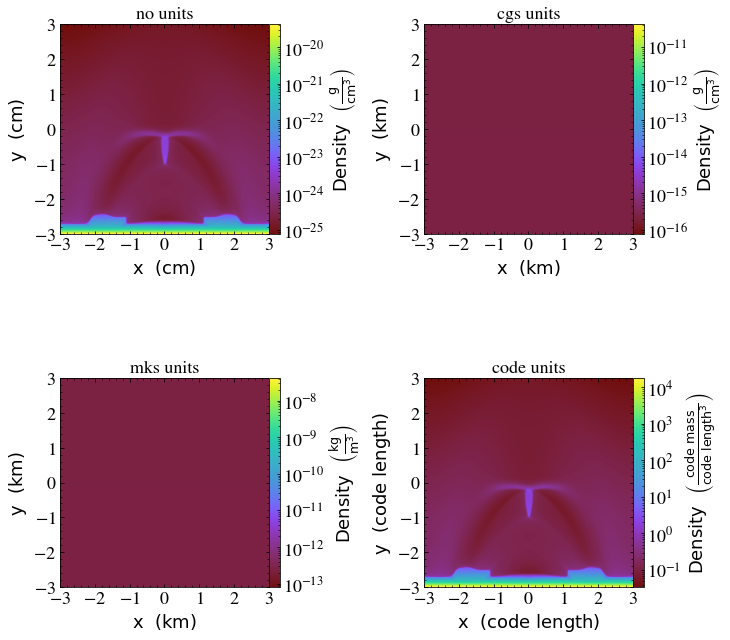

In [9]:
# this example is based on https://yt-project.org/docs/dev/cookbook/complex_plots.html#multiple-slice-multipanel
fig = plt.figure()
grid = AxesGrid(fig, (0.075,0.075,0.85,0.85), nrows_ncols = (2, 2), axes_pad = 2.0, label_mode = "each",
                share_all = True, cbar_location="right", cbar_mode="each", cbar_size="5%", cbar_pad="0%")
for i, (ds_i, title_i) in enumerate(zip(datasets, titles)):
    p = yt.plot_2d(ds_i, 'density')
    p.annotate_title(title_i)
    plot = p.plots['density']
    plot.figure = fig
    plot.axes = grid[i].axes
    plot.cax = grid.cbar_axes[i]
    p._setup_plots()


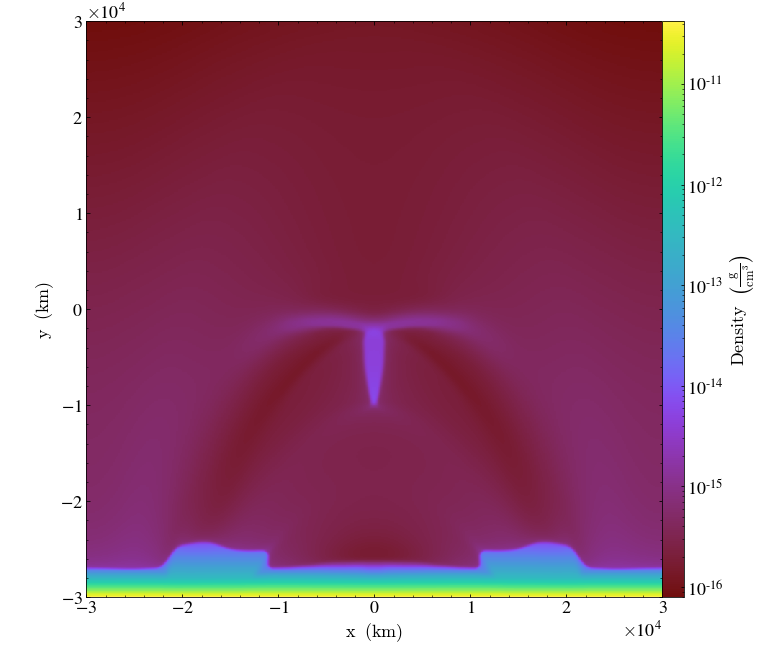

In [10]:
dst = yt.load(prominence, units_override=units, unit_system='cgs')
pt = yt.plot_2d(dst, 'density')
pt.show()

In [10]:
# re-enable log messages
ytlog.setLevel(20)

Note the difference in axis scales, especially the colorbar scale and labels. Of course, you can customise these individually as well. You may have noticed that providing the field `'density'` (obviously) plots the density field.

### 3.2 - Fields and derived fields

To see the fields that are present _in the datfile,_ you can call

In [11]:
# ds.field_list

It should be noted that the fields in the datfile (hence the ones that come straight out of AMRVAC) are always in code units. That's also why the first argument is `'amrvac'`, in order to distinguish them from standard yt fields. However, these are not the only fields that yt knows. To see all fields that yt _thinks_ it knows, you can call

In [12]:
# ds.derived_field_list

Note that these also contain the fields from the datfile itself. All fields with first argument `'gas'` are in the unit system specified during loading. The ones with `'index'` are used internally by yt.

We extended these fields with the _kinetic energy density, sound speed, thermal pressure_ and various others. Since AMRVAC can do simulations in (adiabatic) (magneto)hydrodynamics by setting for example `mhd_energy=.false.` in the parfile, we actually **reconstruct the equation of state** from information contained in the datfile. When these fields are set up, yt will print an info message saying which EoS is used. If yt is unable to reconstruct the EoS it will print a warning stating that the thermal pressure field, and by extension derived fields thereof, are not set.

<font color='red'>**Important note**</font>: Currently the frontend can reconstruct all possible variations of the equation of state. However, when using an _adiabatic EoS_ (running isothermal), AMRVAC uses either `hd_adiab` or `mhd_adiab` for the adiabatic constant which is **NOT** saved to the datfile, but is set in the parfile instead. Since this quantity is needed for an accurate reconstruction, you have to supply the parfile _in addition_ to the datfile.
Thanks to Clément, yt is able to parse AMRVAC's parfile and set the corresponding quantities. This is done through

```python
ds = yt.load(datfile, parfiles=parfile)
```
where `parfile` is either a String or a list of Strings. If it is a list (so multiple parfiles are passed), yt handles this in exactly the same way AMRVAC handles multiple parfiles.

Since the 2.5D dataset here was done in full MHD, yt logs `using the full MHD energy for thermal pressure`, as it should. Note that this is done _exactly once_ when setting up the derived fields, usually when executing a plot command for the first time. All subsequent calls will not have this info message, since these fields have already been set. As a small addition, we show that yt can automatically add the current timestep to the figure as well, and immediately formats it to a convenient time unit.

yt : [INFO     ] 2020-07-05 20:25:54,513 Using full MHD energy for thermal pressure.
yt : [INFO     ] 2020-07-05 20:25:56,474 xlim = -3.000000 3.000000
yt : [INFO     ] 2020-07-05 20:25:56,475 ylim = 0.000000 6.000000
yt : [INFO     ] 2020-07-05 20:25:56,475 xlim = -3.000000 3.000000
yt : [INFO     ] 2020-07-05 20:25:56,476 ylim = 0.000000 6.000000
yt : [INFO     ] 2020-07-05 20:25:56,477 Making a fixed resolution buffer of (('gas', 'thermal_pressure')) 800 by 800



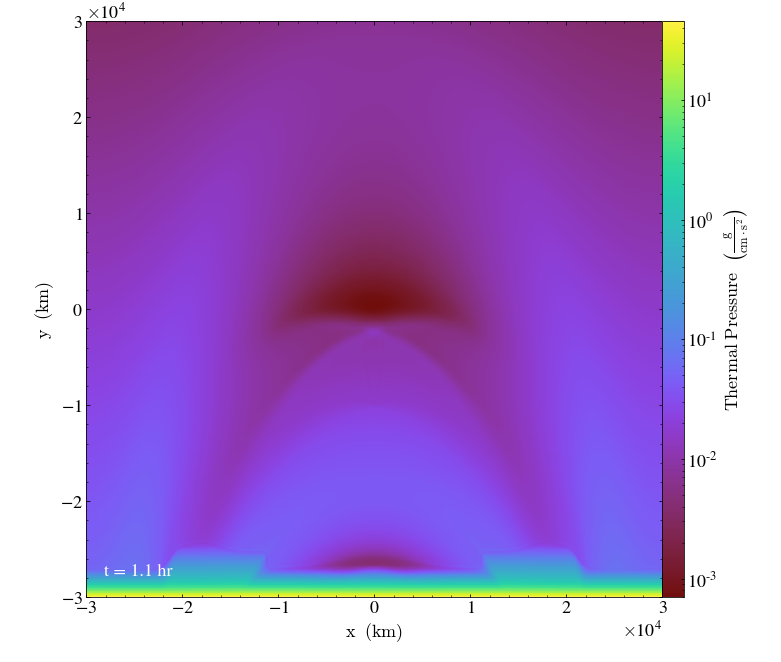

In [13]:
p = yt.plot_2d(ds, 'thermal_pressure')
p.annotate_timestamp()
p.show()

### 3.3 - Magnetic field splitting

AMRVAC has the possibility to do magnetic field splitting, which means that the magnetic field is split into a time-independent and a time-dependent part. In doing so AMRVAC _only_ saves the **time-dependent magnetic field** to the datfile! This means if you use yt to read in a datfile from a simulation that has B0-splitting enabled, you will only plot the perturbed magnetic fields. The dataset of the 2.5D prominence actually has magnetic field splitting enabled, so we will show what this looks like. This is also the perfect time to make users aware of a nice feature yt has to draw streamlines on top of the usual streamline plot / quiver plot, which is based on the method of line integral convolution ([more info here](https://yt-project.org/docs/dev/visualizing/callbacks.html?highlight=line%20integral%20convolution#annotate_line_integral_convolution)). [This blog post](https://blog.yt-project.org/post/LineIntegralConvolution/) is also quite interesting.

Note that the LIC works on any argument you pass it and can hence also be used to draw streamlines of the velocity field as well, or even a user-defined field.

yt : [INFO     ] 2020-07-05 20:25:57,535 xlim = -3.000000 3.000000
yt : [INFO     ] 2020-07-05 20:25:57,535 ylim = 0.000000 6.000000
yt : [INFO     ] 2020-07-05 20:25:57,536 xlim = -3.000000 3.000000
yt : [INFO     ] 2020-07-05 20:25:57,537 ylim = 0.000000 6.000000
yt : [INFO     ] 2020-07-05 20:25:57,538 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



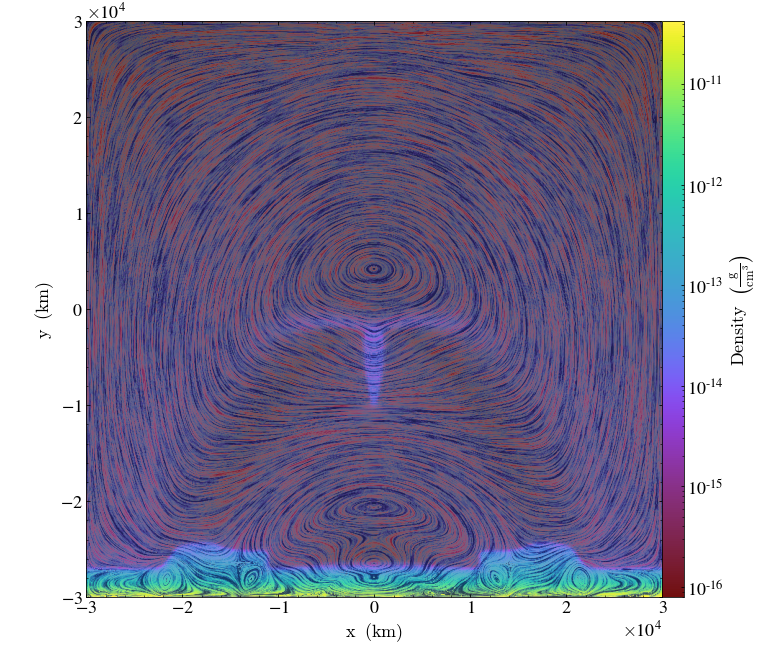

In [14]:
p = yt.plot_2d(ds, 'density')
p.set_cmap('density', 'arbre')
p.annotate_line_integral_convolution('b1', 'b2', lim=(0.5, 0.67), cmap='YlGnBu')

You can play around with the arguments to get different contrasts or results. We note again that the figure above shows the **perturbed magnetic fields**, and _NOT_ the total magnetic field. We are well aware of this limitation and it is actually not possible to fix this with the current (as of v2.2) datfile version. By extension, this also means that all additional quantities (for example additional derived fields) dependent on the magnetic field will be off. <font color='red'>_Please be aware of this in doing so!_</font>

However, thanks to Ileyk El Mellah we have a fix for this, which is explained in the FAQ section below.

# 4. Jet dataset (3D)

Next we move on to the full 3D dataset. We will load this using standard normalisations and a cgs unit system (default).

In [15]:
ds_3d = yt.load(jet, units_override=units)

yt : [WARNING  ] 2020-07-05 20:25:59,498 Overriding code units: Use this option only if you know that the dataset doesn't define the units correctly or at all.
yt : [INFO     ] 2020-07-05 20:25:59,498 Overriding length_unit: 1e+09 cm.
yt : [INFO     ] 2020-07-05 20:25:59,499 Overriding temperature_unit: 1e+06 K.
yt : [INFO     ] 2020-07-05 20:25:59,500 Overriding numberdensity_unit: 1e+09 cm**-3.
yt : [INFO     ] 2020-07-05 20:25:59,566 Parameters: current_time              = 18.0
yt : [INFO     ] 2020-07-05 20:25:59,567 Parameters: domain_dimensions         = [64 64 96]
yt : [INFO     ] 2020-07-05 20:25:59,567 Parameters: domain_left_edge          = [-30. -30.   0.]
yt : [INFO     ] 2020-07-05 20:25:59,568 Parameters: domain_right_edge         = [30. 30. 90.]
yt : [INFO     ] 2020-07-05 20:25:59,569 Parameters: cosmological_simulation   = 0


We first create a simple SlicePlot along the `y` direction. The additional argument `origin='native'` uses the limits from the actual dataset, since yt has the habit of recentering the plot location. `xlim` and `ylim` below refer to the z-limits on the x-axis, and the x-limits on the y-axis. In the INFO logging message we see that z runs from 0 to 90 in code units. If `origin='native'` is omitted (you can try this yourself), yt will recenter the x-axis with `z=0` in the middle (so from -45 to 45). 

yt : [INFO     ] 2020-07-05 20:25:59,944 Using full MHD energy for thermal pressure.
yt : [INFO     ] 2020-07-05 20:26:00,701 xlim = 0.000000 90.000000
yt : [INFO     ] 2020-07-05 20:26:00,702 ylim = -30.000000 30.000000
yt : [INFO     ] 2020-07-05 20:26:00,703 xlim = 0.000000 90.000000
yt : [INFO     ] 2020-07-05 20:26:00,703 ylim = -30.000000 30.000000
yt : [INFO     ] 2020-07-05 20:26:00,704 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



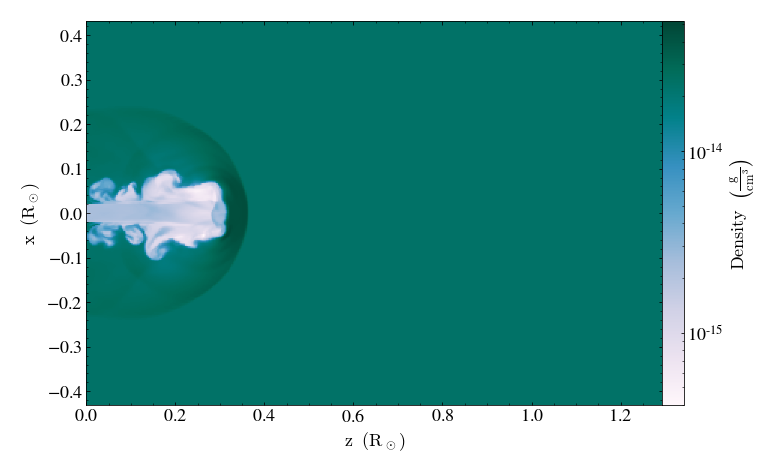

In [16]:
s1 = yt.SlicePlot(ds_3d, 'y', 'density', origin='native')
s1.set_cmap('density', 'PuBuGn')
s1.set_axes_unit('Rsun')

### 4.1 - Defining a custom field

Say you want another field which is not present in the datfile, or in yt's list of derived fields. Doing so is quite straightforward and very well explained in the [yt docs](https://yt-project.org/docs/dev/cookbook/calculating_information.html#simple-derived-fields), but we'll give an example here nevertheless. Below we replot the slice we just created, but use the Alfvén velocity instead.

In [17]:
def alfven_velocity(field, data):
    b2 = data['b1']**2 + data['b2']**2 + data['b3']**2
    return np.sqrt(b2/data['rho'])

Note that calling `data['b1']` or `data['rho']` returns the fields in **code units**, since these fields come straight from the datfile as we're calling them by their AMRVAC names. That's why we don't take the magnetic constant into account here. `b2` will therefore be in units of `code_magnetic**2` and similarly `data['rho']` will be in `code_density`. This method will hence return something with units `code_magnetic / sqrt(code_density)` which yt will automatically interpret as a velocity. So when we add this derived field to the dataset we specify it in the same units as all the rest (cgs, so cm/s), and yt will automatically convert the result from the above method to a dimensionfull velocity, using the `unit_velocity`. Neat, isn't it?

On top of this yt will not allow you to add a field with inconsistent units. So say you try and add the derived field above in units of kg or so, it will throw an error saying the units don't match. This is quite handy as an additional check.

It's perhaps worth mentioning here that the above field is called _for every block in the dataset_, so the `data` object is a dictionary containing the Numpy-arrays for a specific block. This is good to know in case you want to do calculations with it.

In [18]:
ds_3d.add_field(('gas', 'alfven_velocity'), function=alfven_velocity, units='cm/s', sampling_type='cell')

yt : [INFO     ] 2020-07-05 20:26:01,383 xlim = 0.000000 90.000000
yt : [INFO     ] 2020-07-05 20:26:01,383 ylim = -30.000000 30.000000
yt : [INFO     ] 2020-07-05 20:26:01,384 xlim = 0.000000 90.000000
yt : [INFO     ] 2020-07-05 20:26:01,384 ylim = -30.000000 30.000000
yt : [INFO     ] 2020-07-05 20:26:01,385 Making a fixed resolution buffer of (('gas', 'alfven_velocity')) 800 by 800



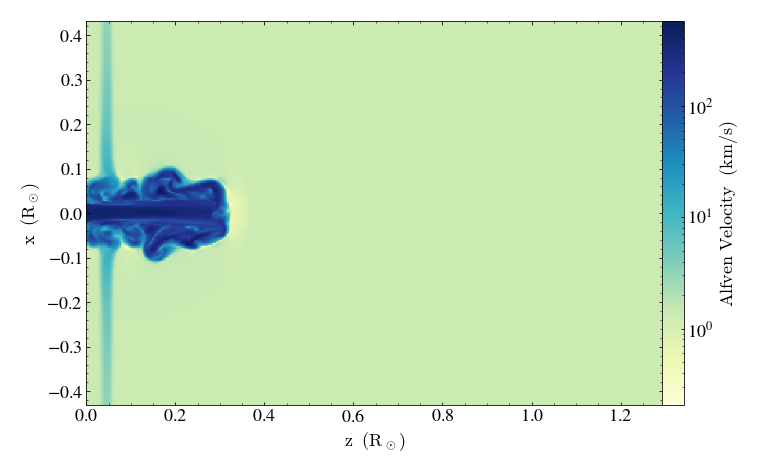

In [19]:
s2 = yt.SlicePlot(ds_3d, 'y', 'alfven_velocity', origin='native')
s2.set_cmap('alfven_velocity', 'YlGnBu')
s2.set_axes_unit('Rsun')
s2.set_unit('alfven_velocity', 'km/s')

### 4.2 - Volume renderings

As a last example we show off one of yt's beautiful features: a volume rendering. yt basically casts rays and evaluates a given transfer function for each ray. These transfer functions can be user-defined, as we'll show here. There is a lot of information on volume rendering in the [yt cookbook](https://yt-project.org/docs/dev/visualizing/volume_rendering.html#volume-rendering), so make sure to check that out.

The piece of code below first calculates the minimum and maximum density values, which are used to define a custom transfer function. Please note that these are really data-set dependent, and tweaking the values will need multiple tries. The best advice that we can give here is to first locate some interesting density (or other field) values, and use those to create a transfer function. You can plot the transfer function to see what it looks like, and adjust if needed. Again, see the cookbook for detailed examples.

yt can also create beautiful 3D isosurfaces and export them to a format easily readable by Meshlab or Blender. Take a look [here](https://yt-project.org/docs/dev/visualizing/sketchfab.html?highlight=meshlab).

In [20]:
ad = ds_3d.all_data()
rho_max = ad['density'].max()
rho_min = ad['density'].min()
print(rho_min)
print(rho_max)

3.499427732888977e-16 g/cm**3
5.1941667175786445e-14 g/cm**3


yt : [INFO     ] 2020-07-05 20:26:02,847 Setting default field to ('gas', 'density')


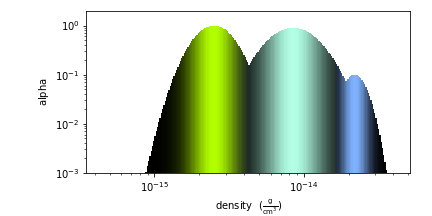

In [21]:
sc = yt.create_scene(ds_3d, lens_type='perspective')

source = sc.get_source()
source.set_field('density')
source.set_log(True)

bounds = (rho_min, rho_max)
tf = yt.ColorTransferFunction(np.log10(bounds))
# height = [R, G, B, alpha]
tf.add_gaussian(np.log10(2.2e-14), width=0.01, height=[0.5, 0.7, 1.0, 0.1])
tf.add_gaussian(np.log10(8.5e-15), width=0.05, height=[0.7, 1.0, 0.9, 0.9])
tf.add_gaussian(np.log10(2.5e-15), width=0.03, height=[0.7, 1.0, 0.0, 1.0])

source.tfh.tf = tf
source.tfh.bounds = bounds
source.tfh.plot()

Below we set some values for the camera. Note that we use the `Rsun` unit to define the locations, since we can easily use this to refer back to the sliceplot we made earlier. This is the best way to get an idea where you want to position the camera, and on which point it should focus.

yt : [INFO     ] 2020-07-05 20:26:20,399 Rendering scene (Can take a while).


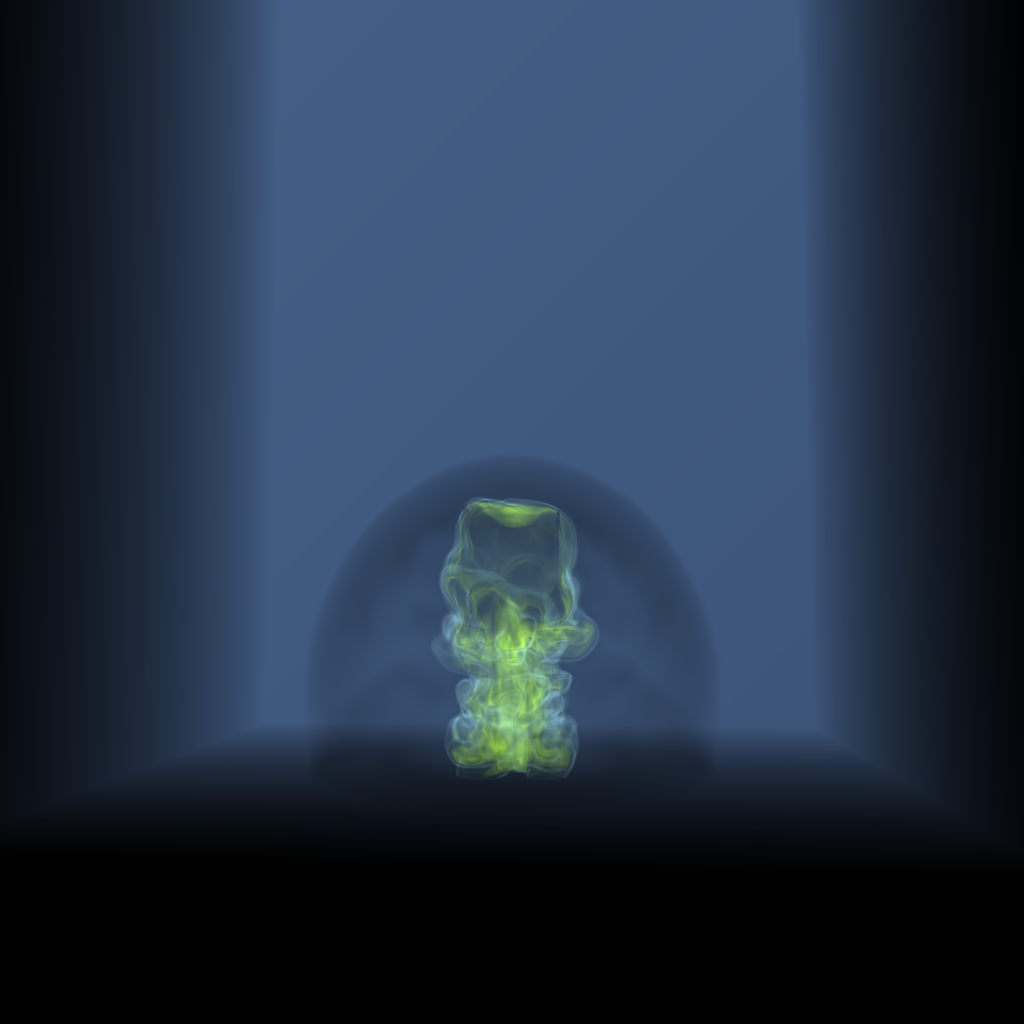

In [23]:
sc.camera.focus = ds_3d.arr([0, 0, 0.3], 'Rsun')
sc.camera.resolution = 1024
sc.camera.north_vector = [0, 0, 1]
sc.camera.position = ds_3d.arr([1.2, 0.1, 0.2], 'Rsun')

sc.render()
sc.show(sigma_clip=5)

# **FAQ**

These are some frequently asked questions that we got from various AMRVAC users over the last few months. Since we are getting these on a regular basis they are included here, along with possible workaround/fixes we have came up with. Note that these will (probably) be extended in the future.

## 1. How do I access the full data as arrays?

This is by far the most frequently asked question we got. When you want to work with Numpy data, you have to realise that your dataset probably has multiple AMR levels. This means that it can not be 'easily' represented by a plain Numpy matrix, and interpolation is needed to a certain grid level. Luckily, yt provides such methods, and they are straightforward to use. We include an example below, more information can be found [here](https://yt-project.org/docs/dev/examining/low_level_inspection.html#examining-grid-data-in-a-fixed-resolution-array). The most easy way is to make use of `covering_grid`. Note that this can take a while, especially for large datasets.

In [24]:
# Say we interpolate to AMR level 4
level = 4
rho_l4 = ds.covering_grid(level, left_edge=ds.domain_left_edge, 
                          dims=ds.domain_dimensions * ds.refine_by**level)['density']

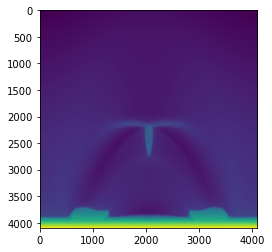

In [25]:
# now you can for instance create a matplotlib figure and plot the data, or do other stuff with it
fig, ax = plt.subplots(1)
density = rho_l4[:, :, 0].value
# rotate 90 degrees counterclockwise due to imshow's convention of the origin (top-left)
ax.imshow(np.rot90(np.log10(density)))  
plt.show()

## 2. Thermal pressure is defined, but I can't find the temperature?

That's correct, since we didn't include the temperature yet in the list of default derived fields. That's a planned extension (together with various other fields). It turns out this particular field is not so straightforward to handle (we have some issues with unit conversions), but in the meantime you can "hack" it like so:

In [26]:
def temperature(field, data):
    # make pressure and density dimensionless
    p = data['thermal_pressure'] / data.ds.pressure_unit
    rho = data['density'] / data.ds.density_unit
    # make temperature dimensionfull
    return (p / rho) * data.ds.temperature_unit

yt : [INFO     ] 2020-07-05 20:27:15,752 xlim = -3.000000 3.000000
yt : [INFO     ] 2020-07-05 20:27:15,753 ylim = 0.000000 6.000000
yt : [INFO     ] 2020-07-05 20:27:15,753 xlim = -3.000000 3.000000
yt : [INFO     ] 2020-07-05 20:27:15,754 ylim = 0.000000 6.000000
yt : [INFO     ] 2020-07-05 20:27:15,755 Making a fixed resolution buffer of (('gas', 'temperature')) 800 by 800



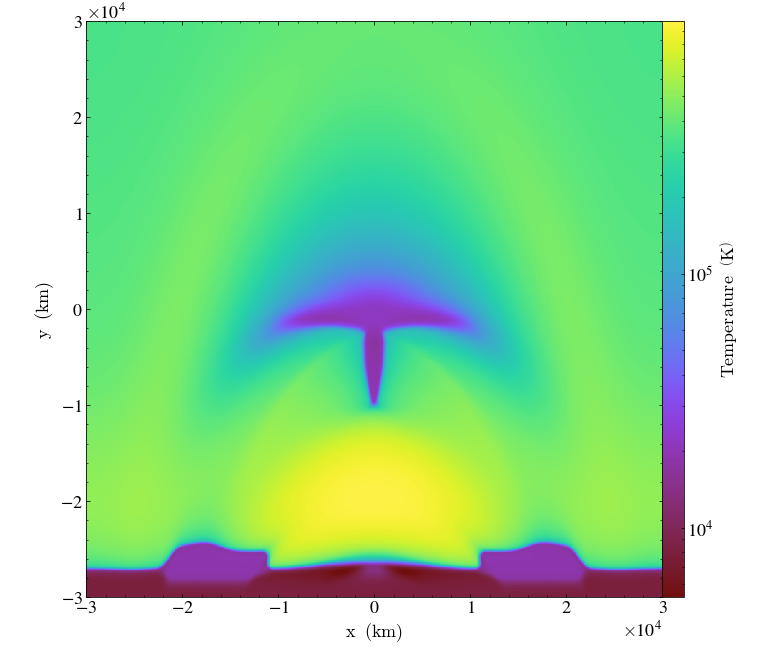

In [27]:
ds.add_field(('gas', 'temperature'), function=temperature, units='K', sampling_type='cell')
p = yt.plot_2d(ds, 'temperature')
p.show()

## 3. My dataset has magnetic field splitting. Is there still a way to work with the magnetic field?

## <font color='red'>Warning</font>

<font color='red'>
Recent use cases have shown that the workaround described here works in order to have access to the full magnetic field in yt. However, the thermal pressure fields and ALL derived fields thereof are WRONG for datasets with B0 splitting enabled, since yt has been configured to use the standard magnetic field parameters in the datfile (which in this case are the perturbed variables) when calculating thermal pressure and such.
    
This problem affects (that we know of) the fields thermal_pressure, sound_speed, magnetic_energy_density, and all user-defined fields based on thermal pressure and/or magnetic fields.
    
We're trying to fix this as soon as possible.
</font>

Yes and no. No in the sense that it's not possible with the default AMRVAC dataset. Yes in the sense that there exists a workaround to achieve this. What you essentially want to do is "force" AMRVAC to save additional variables to the datfile itself (just as is done with the .vtu files). Please note that this will increase the size of the datfile considerably, and should _NOT_ be done by default. The steps to achieve this are as follows:

1. In the `usr_init()` subroutine of the `mod_usr.t` file, add the following lines:
```Fortran
    usr_add_aux_names => specialvarnames_output
    usr_modify_output => set_output_vars
```
The first line is similar as saving additional variables to the .vtu file, and contains the naming conventions of the additional variables.
2. Define a new subroutine `set_output_vars(ixI^L,ixO^L,qt,w,x)`, where you can calculate any variable you want (including the total magnetic field). Say you did that and stored it in a variable called `Btotal`, you simply add it to AMRVAC's `w`-array like so
```Fortran
    w(ixO^S, 1) = Btotal(ixO^S,1)
    w(ixO^S, 2) = Btotal(ixO^S,2)
    w(ixO^S, 3) = Btotal(ixO^S,3)
```
3. That's it. If you named these variables `(Bt1, Bt2, Bt3)` these will now show up in the datfile when calling `ds.field_list`.

**NOTE**: yt recognises all variables in the datfile. However, additional variables (that is, the ones that are not there by default) have no units attached to them. That means that you still have to define a derived field for them. Luckily that is not so difficult in this case (all "new" variables are dimensionless):

```python
def total_b1(field, data):
    Bt1 = data['Bt1']
    return Bt1 * data.ds.magnetic_unit

ds.add_field(('gas', 'Bt1'), function=total_b1, units='gauss', sampling_type='cell')
```
and so on for the other variables.

## 4. I have a spherical dataset and I want to slice it along r

This is an application of the `geometry_override` specific to the AMRVAC frontend. What we are going to do here is "force" a spherical dataset into a Cartesian geometry, and use that to plot the slice. When loading, you'll notice yt logging a warning that the standard geometry is being overridden. The granulation is due to the dataset being low-resolution.

This example is based on a notebook and dataset provided by Christine Verbeke.

In [28]:
units = dict(time_unit=(3600, 's'), length_unit=(6.955e8, 'm'), mass_unit = (1.6726e-19,'kg'))
ds = yt.load(solarwind, units_override=units, geometry_override='Cartesian')

yt : [WARNING  ] 2020-07-05 20:27:32,040 Overriding geometry, this may lead to surprising results.
yt : [WARNING  ] 2020-07-05 20:27:32,041 Overriding code units: Use this option only if you know that the dataset doesn't define the units correctly or at all.
yt : [INFO     ] 2020-07-05 20:27:32,041 Overriding length_unit: 6.955e+08 m.
yt : [INFO     ] 2020-07-05 20:27:32,042 Overriding time_unit: 3600 s.
yt : [INFO     ] 2020-07-05 20:27:32,042 Overriding mass_unit: 1.6726e-19 kg.
yt : [INFO     ] 2020-07-05 20:27:32,157 Parameters: current_time              = 3.0
yt : [INFO     ] 2020-07-05 20:27:32,157 Parameters: domain_dimensions         = [300  32  96]
yt : [INFO     ] 2020-07-05 20:27:32,158 Parameters: domain_left_edge          = [21.5         0.51183251  0.        ]
yt : [INFO     ] 2020-07-05 20:27:32,158 Parameters: domain_right_edge         = [421.5          2.62976014   6.28318531]
yt : [INFO     ] 2020-07-05 20:27:32,159 Parameters: cosmological_simulation   = 0


yt : [INFO     ] 2020-07-05 20:27:37,356 Using full MHD energy for thermal pressure.
yt : [INFO     ] 2020-07-05 20:27:37,832 xlim = 0.511833 2.629760
yt : [INFO     ] 2020-07-05 20:27:37,833 ylim = 0.000000 6.283185
yt : [INFO     ] 2020-07-05 20:27:37,833 xlim = 0.511833 2.629760
yt : [INFO     ] 2020-07-05 20:27:37,834 ylim = 0.000000 6.283185
yt : [INFO     ] 2020-07-05 20:27:37,835 Making a fixed resolution buffer of (('gas', 'velocity_1')) 800 by 800



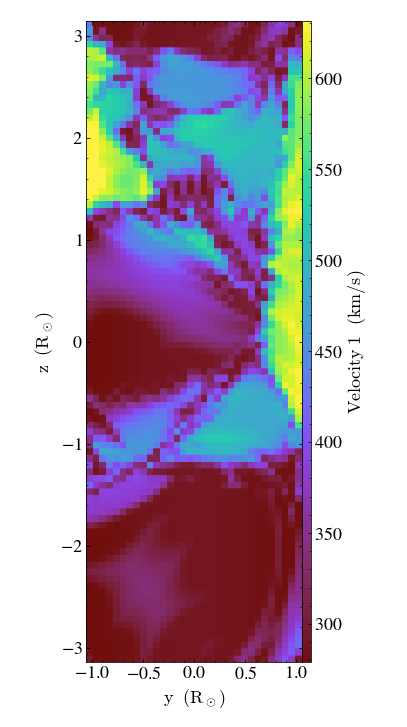

In [29]:
s = yt.SlicePlot(ds, axis='x', fields='velocity_1', center='c')
s.set_log('velocity_1', False)
s.set_cmap('velocity_1', 'arbre')
s.set_unit('velocity_1', 'km/s')
s.set_figure_size(3)
s.show()

You'll notice that creating the slice produces a nice rectangular image, which can be converted into a longitude-latitude map. To see the difference with creating a slice from a spherical dataset, we do the exact same thing below but without using the `geometry_override` keyword argument. 


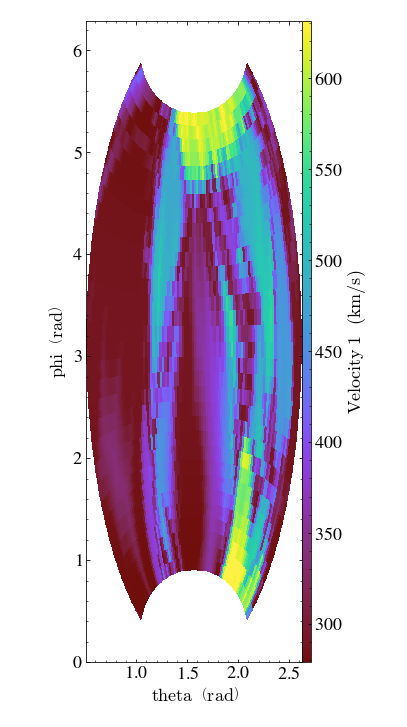

In [30]:
ytlog.setLevel(40)
units = dict(time_unit=(3600, 's'), length_unit=(6.955e8, 'm'), mass_unit = (1.6726e-19,'kg'))
ds = yt.load(solarwind, units_override=units)
s = yt.SlicePlot(ds, axis='r', fields='velocity_1', center='c')
s.set_log('velocity_1', False)
s.set_unit('velocity_1', 'km/s')
s.set_figure_size(3)
s.show()